#Import dependencies 

In [302]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Populating the interactive namespace from numpy and matplotlib


#### Data import

In [304]:
import pandas as pd


data = pd.read_csv('/content/BATADAL_dataset03.csv') # rea the data using pandas

X = data.drop(['DATETIME','ATT_FLAG'],axis=1) # drop datetime (not usefull ) and drop ATT_flag bz it represnt label
y = data['ATT_FLAG'] # get the label


# MinMax scaller

In [306]:
from sklearn.preprocessing import MinMaxScaler
model = MinMaxScaler() # mimax scaller to max our dat values between (0-1) that's gonna help the model too get good result
X = model.fit_transform(np.array(X)) # train the mimax scaller model and transfrom the dat
X.shape , y.shape #be sure we have the same shape for input data and output data

((8761, 43), (8761,))

# Split data into train , test , validation

In [307]:
from sklearn.model_selection import train_test_split
#split our data into train, validation and test
x1, X_test, y1, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)  # first split data into test and validation + train (2nd part data)
X_train, X_valid, y_train, y_valid = train_test_split(
     x1, y1, test_size=0.2, random_state=42) # split 2nd part of data into train and validation

# model

In [308]:
m = 64 # batch size
n_z = 2 # latent space size
encoder_dim1 = 64 # dim of encoder hidden layer
decoder_dim = 64 # dim of decoder hidden layer
decoder_out_dim = 43 # dim of decoder output layer
activ = 'relu' # activation function of nodes
optim = Adam(lr=0.001) # optimzer (update wieghts while backpropagaion)

n_x = X_train.shape[1] # input dshpe
n_y = 1 #label shape


n_epoch = 50 #  nb epoch (how many time we need to repeat training phase)


X = Input(shape=(n_x,))  #input layer for X
label = Input(shape=(n_y,)) # input layer for labl

inputs = concat([X, label]) # concat X input layer with label input layer



encoder_h = Dense(encoder_dim1, activation=activ)(inputs) # encoder girst hidden layer with dimmension None, 64
encoder_h1 = Dense(32, activation=activ)(encoder_h) # encoder second hidden layer with dimmension None, 32
mu = Dense(n_z, activation='linear')(encoder_h1) # Mu layer with linear activation  and nz dimension
l_sigma = Dense(n_z, activation='linear')(encoder_h1) # Sigma layer with linear activation  and nz dimension

z1 = concat([mu, l_sigma]) # concat sigma and me
z = Dense(2, activation=activ)(z1) #laten space (the code)

# merge latent space with label
zc = concat([z, label])

decoder_hidden = Dense(32, activation=activ)(zc) # decoder hidden layer 
outputs = Dense(decoder_out_dim, activation='sigmoid')(decoder_hidden) # output layer

cvae = Model([X, label], outputs) # inti the model 


### Defining loss
If you're familiar with autoencoders, you probably understand that they are backpropagated using reconstruction loss. This is a measure of error between the input **X** and the decoded output **X_hat**. In VAEs, our loss is the sum of reconstruction error and the kullback-leibler divergence between our $\mu$ and log-$\sigma$ and the standard normal.

In this notebook I've defined the `vae_loss` function, which we'll use to optimize our model. I've also broken it down into the `KL_loss` and `recon_loss` subcomponents so that we can track these values as metrics during training.

In [311]:
# read above
def vae_loss(y_true, y_pred): 
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

# compile model

In [312]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss]) 
# compile the model with optimzer = adam , loss =  VAE , metrics = [KL_loss, recon_loss]

# Present Archi

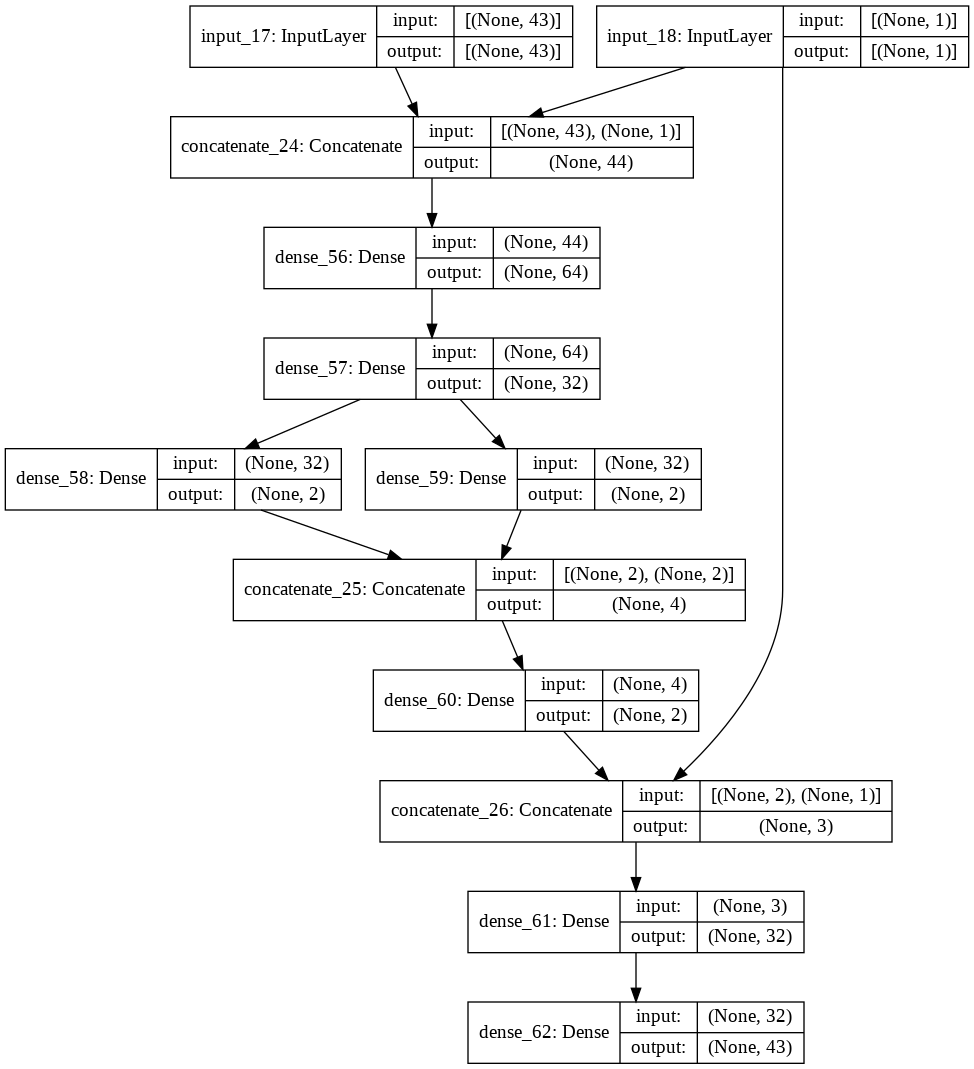

In [314]:
# show the archi of the model
import tensorflow as tf
tf.keras.utils.plot_model(cvae, to_file='img.png', show_shapes=True)

In [317]:
#init keras backend session
import keras
keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())

#Train

In [318]:
# compile and fit

import keras
import tensorflow as tf


# compile and fit
#convert X_train to numpy array (model don't accept list)
X_train = np.array(X_train)
# train model batch size = m ,.... earlystopping to avoid overfitting 
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m,shuffle=True, epochs=200,
							validation_data=([X_valid,y_valid],X_valid),
							callbacks = [EarlyStopping(patience = 5)])

Train on 5606 samples, validate on 1402 samples
Epoch 1/200
5606/5606 [==============================] - 0s 77us/sample - loss: 26.6495 - KL_loss: 0.8486 - recon_loss: 25.8008 - val_loss: 23.1524 - val_KL_loss: 1.1423 - val_recon_loss: 22.0101
Epoch 2/200
5606/5606 [==============================] - 0s 29us/sample - loss: 21.6880 - KL_loss: 0.8984 - recon_loss: 20.7896 - val_loss: 20.8505 - val_KL_loss: 0.7369 - val_recon_loss: 20.1136
Epoch 3/200
5606/5606 [==============================] - 0s 36us/sample - loss: 20.1492 - KL_loss: 0.6258 - recon_loss: 19.5234 - val_loss: 19.7952 - val_KL_loss: 0.5014 - val_recon_loss: 19.2938
Epoch 4/200
5606/5606 [==============================] - 0s 35us/sample - loss: 19.3847 - KL_loss: 0.4557 - recon_loss: 18.9290 - val_loss: 19.2482 - val_KL_loss: 0.3991 - val_recon_loss: 18.8491
Epoch 5/200
5606/5606 [==============================] - 0s 33us/sample - loss: 18.9526 - KL_loss: 0.3595 - recon_loss: 18.5931 - val_loss: 18.8842 - val_KL_loss: 0.317

#Plot graph

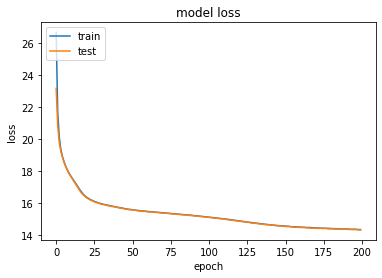

In [319]:
#plot the graph
plt.plot(cvae_hist.history['loss']) # train loss history 
plt.plot(cvae_hist.history['val_loss']) # validation loss history 
plt.title('model loss') # title 
plt.ylabel('loss') # ylabel titl
plt.xlabel('epoch') # xlabel w-axis title
plt.legend(['train','test'], loc='upper left') # add legend (box that represent  color of data)
plt.show() # show plot
 

#Read dataset4 and get input and label

In [322]:
from sklearn.utils import shuffle

data4 = pd.read_csv('/content/BATADAL_dataset04.csv') # read data 4 that represet test data


data4[data4[' ATT_FLAG']==-999] = 1 # connvert value -999 to 1 to better understanding and proper working 
X_data4 = data4.drop(['DATETIME',' ATT_FLAG'],axis=1) # drop datetime (not usefull ) and drop ATT_flag bz it represnt label

y_data4 = data4[' ATT_FLAG'] # get label 
X_data4 = model.transform(X_data4)  # scale the data

#concat test data from data3 with test data4

In [323]:
new_Xtest = np.concatenate((X_test,X_data4))# concat test data from data3 with test data4
new_y = np.concatenate((y_test,y_data4)) #concat label test data3 with labe test data 4

final_xtest , final_y = shuffle(new_Xtest,new_y, random_state=0)  # shuffle the data 
final_xtest = final_xtest[:100] # get only the first 100 rows to better plot
final_y = final_y[:100] # get only the first 100 rows to better plot

#Get threeshold

In [325]:
from sklearn.metrics.pairwise import euclidean_distances
y_pred = [] # list that contain prediction

#calculate centile value 
# get the centile value from train data to know the threeshold vlaue for classification
for j in range(len(X_train)):
  out = np.array([0]) # label as 0 
  inp = np.array([X_train[j]]) # input 
  prd0 = cvae.predict([inp,out]) #get the prediction 
 
  
  dst0 = euclidean_distances(np.reshape(X_train[j],(-1,43)),prd0) # get ecludian distance 
  y_pred.append(dst0) # add the distance to y_pred to get the value of centile (threeshold)

  


In [326]:
anomaly_threeshold = np.percentile(y_pred,90)# get the centile (represent threeshold)
anomaly_threeshold 

1.3593881371114847

#Get prediction on test data

In [327]:
from sklearn.metrics.pairwise import euclidean_distances
y_pred = [] # prediction

for j in range(len(final_xtest)):
  out = np.array([0]) #label 0 
  inp = np.array([final_xtest[j]]) # inpur data
  prd0 = cvae.predict([inp,out]) # get prediction 
 
  
  dst0 = euclidean_distances(np.reshape(final_xtest[j],(-1,43)),prd0) # get ecludian distance betwwen real output and prediction
  

  if dst0 < anomaly_threeshold : #if dst < anomaly_threeshold mean its not attack
    y_pred.append(0)
  else:  # attack (outlier)
    y_pred.append(1)

#Calculate accuracy

In [328]:
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
# accyraccy and f1 score
acc(final_y,y_pred) , f1(final_y,y_pred) 

(0.98, 0.9846153846153847)

#Plot 

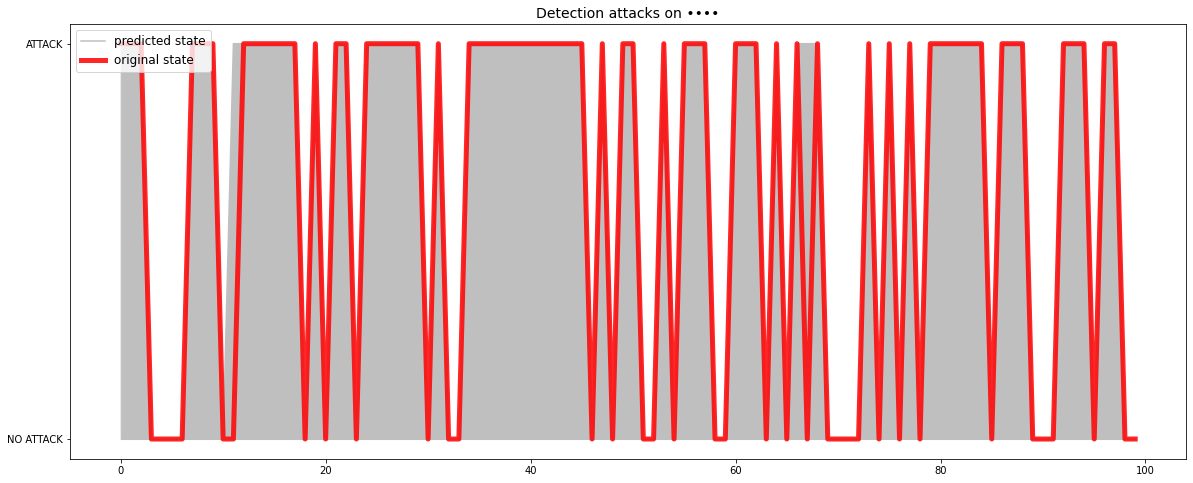

In [329]:
# plot figures
shade_of_gray = '0.75'
f, axes = plt.subplots(figsize = (20,8))  #init plot
axes.plot(y_pred, color = shade_of_gray,label = 'predicted state') # plot prediction
axes.fill_between(range(0,len(y_pred)), y_pred ,interpolate=True, color=shade_of_gray)  #fill between prdiction 
axes.plot(final_y, color = 'r', alpha = 0.85, lw = 5, label = 'original state') # plot original state
axes.set_title('Detection attacks on ••••', fontsize = 14) # titile 
axes.set_yticks([0,1]) #y-axis range
axes.set_yticklabels(['NO ATTACK','ATTACK'])  # y-axis labels 
axes.legend(fontsize = 12, loc = 2) #add legend box that represent color for every label